<h4> Libraries that will be used in the work</h4> 

In [613]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from matplotlib.ticker import MaxNLocator

<h4>Downloading data from csv files to pandas tables</h4>

In [597]:

train_data = pd.read_csv('data/train_titanic.csv')
test_data = pd.read_csv('data/test_titanic.csv')


<h4>Initialization of the main functions, which will be used for cleaning and preparing data for processing</h4>

In [598]:
def del_column(columnToDel, data):
    data.drop(columnToDel, axis=1, inplace=True)


def clean_data(columnToDel, data):
    rowsNumber, columnsNumber = data.shape

    zero_counts = (data == 0).sum()
    nan_counts = data.isnull().sum()

    zero_percentages = (zero_counts / rowsNumber) * 100
    nan_percentages = (nan_counts / rowsNumber) * 100

    for columnName in zero_counts.index:
        if (((zero_counts[columnName] + nan_counts[columnName]) == rowsNumber) or (nan_percentages[columnName] >= 55) or (zero_percentages[columnName] >= 95)):
            data.drop(columnName, axis=1, inplace=True)
            columnToDel.append(columnName)

def fill_data(data):
    for columnName in data.columns:
        if data[columnName].isnull().sum() > 0:

            if data[columnName].dtype in ['float64', 'int64']:

                    mean_value = data[columnName].mean()  
                    data[columnName].fillna(mean_value, inplace=True)
            else:

                    mode_value = data[columnName].mode()[0] 
                    data[columnName].fillna(mode_value, inplace=True)


def column_to_categorical(categorical_features, data):
    for feature in categorical_features:
        data[feature] = pd.Categorical( data[feature], ordered=True) 


def format_column_name(col_name):
    formatted = '_'.join( col_name.replace(' ', '_').split('_'))
    return formatted

def one_hot_encoding(data, nominal_features):

    nominal_features = list(nominal_features)
    data = pd.get_dummies(data, columns=nominal_features)
    data.columns = [format_column_name(col) for col in data.columns]
    

    categorical_columns = data.select_dtypes(include=['bool']).columns
    for feature in categorical_columns:
        data[feature] = data[feature].astype(int)
        data[feature] = pd.Categorical(data[feature])
    
    return data, categorical_columns

def check_column(train_data, test_data):
    columns_in_train_not_in_test = set(train_data.columns) - set(test_data.columns)
    columns_in_test_not_in_train = set(test_data.columns) - set(train_data.columns)
    columns_in_both = set(train_data.columns) & set(test_data.columns)

    print(f"Сolumns in train_data, but not in test_data: {columns_in_train_not_in_test}")
    print(f"Column in test_data, but not in train_data: {columns_in_test_not_in_train}")
    print(f"Column in both DataFrames: {columns_in_both}")

    return columns_in_train_not_in_test


<h4>Display the first five rows of data for visual analysis and use the describe method to learn more about the data</h4>

In [599]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
print(train_data.head())

   PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4            5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S


In [600]:
train_data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<h4>Also choose columns, which could be deleted fron the data set</h4>

In [601]:
columnToDel = [
    # Customer ID doesn't have any effect on our data
    'PassengerId',
    # These columns have too many unique feature 
    'Name',
    'Ticket'
]

<h4>Separate data features for categorical and nominal for the next processing</h4>

In [592]:
categorical_features = {"Embarked", "Sex", "Pclass" } 
nominal_features = {"Embarked", "Sex"}

<h4>Data preparation</h4>

In [602]:
del_column(columnToDel, test_data)
clean_data(columnToDel, test_data)
fill_data(test_data)
#column_to_categorical(categorical_features, test_data)
test_data, new_nominal_features = one_hot_encoding(test_data, nominal_features)

In [ ]:
del_column(columnToDel, train_data)
clean_data(columnToDel, train_data)
fill_data(train_data)
#column_to_categorical(categorical_features, train_data)
train_data, new_nominal_features = one_hot_encoding(train_data, nominal_features)



In [ ]:
categorical_features = categorical_features - nominal_features 
categorical_features = categorical_features | set(new_nominal_features)

print(categorical_features)

{'Sex_male', 'Embarked_S', 'Pclass', 'Embarked_C', 'Embarked_Q', 'Sex_female'}


In [605]:
print(train_data.head())

   Survived  Pclass   Age  SibSp  Parch     Fare Sex_female Sex_male Embarked_C Embarked_Q Embarked_S
0         0       3  22.0      1      0   7.2500          0        1          0          0          1
1         1       1  38.0      1      0  71.2833          1        0          1          0          0
2         1       3  26.0      0      0   7.9250          1        0          0          0          1
3         1       1  35.0      1      0  53.1000          1        0          0          0          1
4         0       3  35.0      0      0   8.0500          0        1          0          0          1


<h4>First of all, we analyzed the target variable and categorical features using histograms and pie charts to understand their distributions and identify potential imbalances or irregularities</h4>

<Axes: xlabel='Survived'>

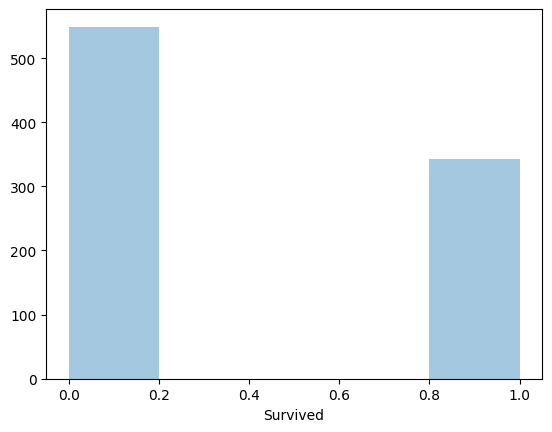

In [611]:
sns.distplot(train_data["Survived"], kde=False)

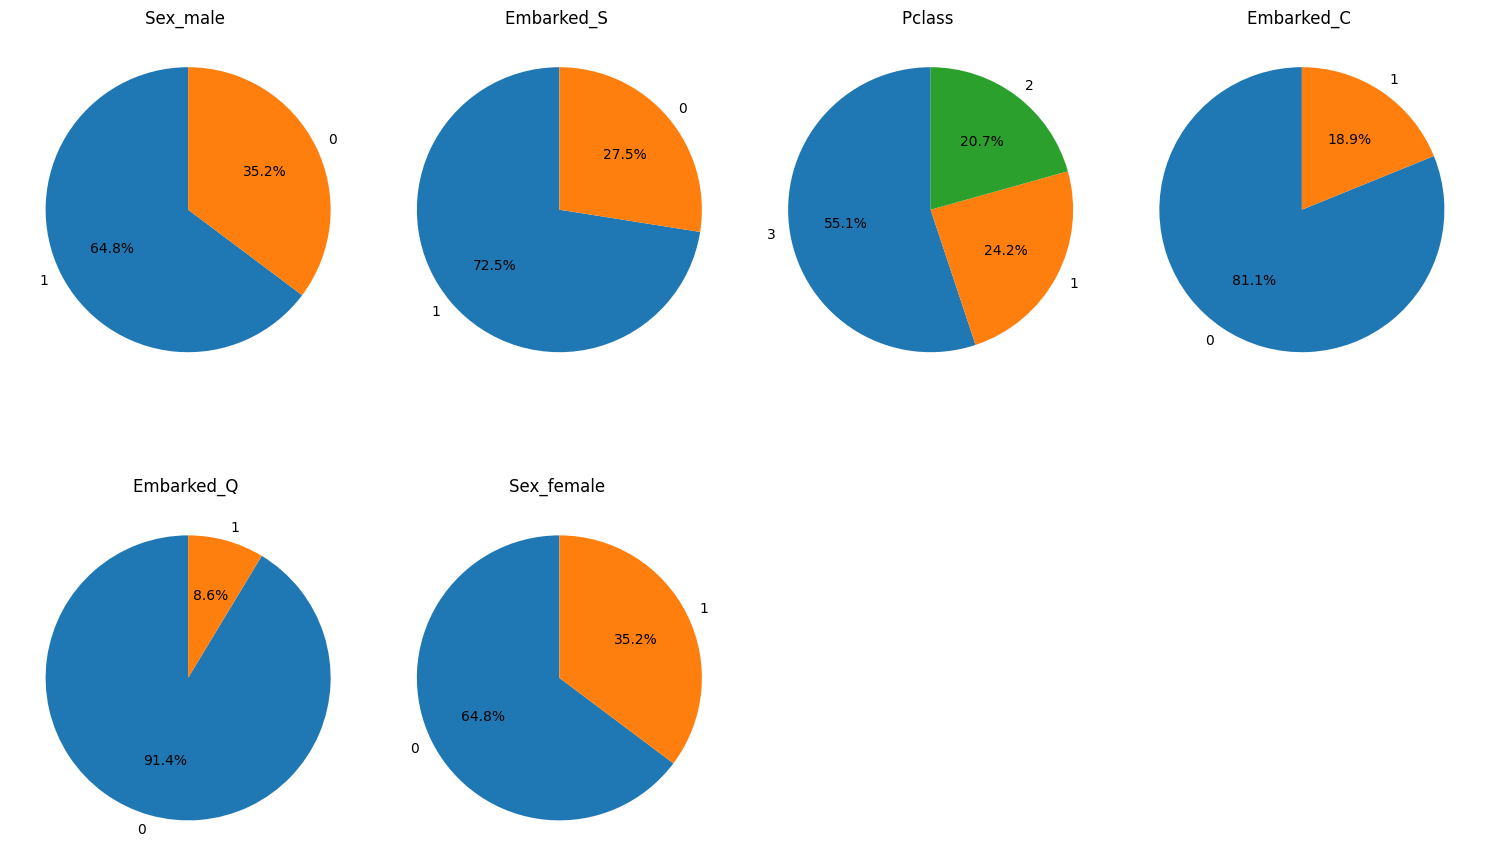

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5 * 2))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    value_counts = train_data[col].value_counts() 
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{col} ')

for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<h4>In this analysis, a correlation heatmap is generated to visualize the relationships between all features in the dataset. The heatmap highlights the strength of correlations. That can help as to choose which columns we could delete</h4>

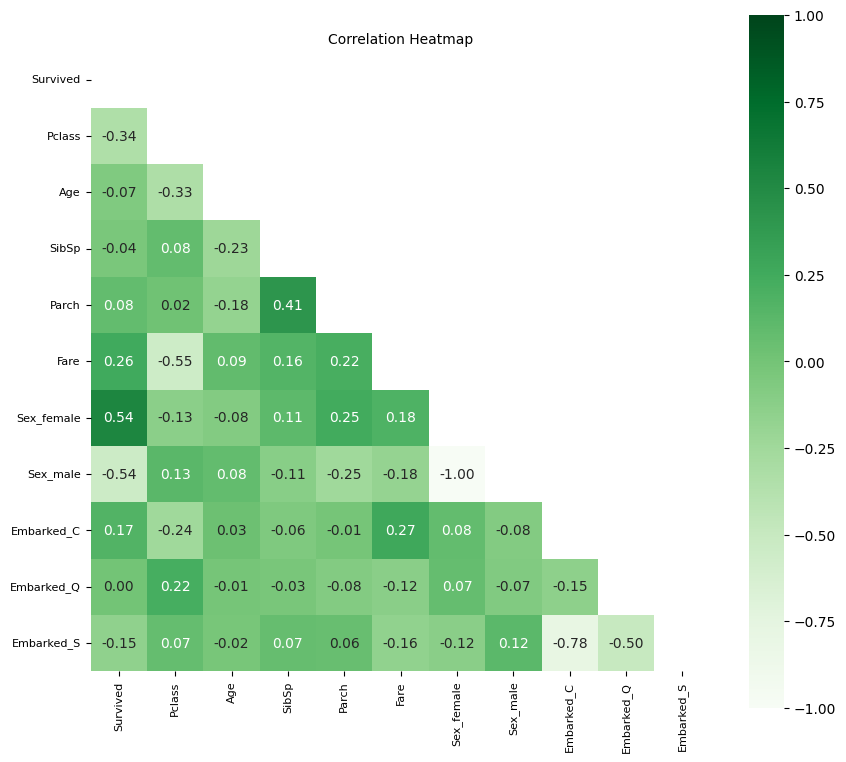

In [607]:
corrMatt = train_data.corr() 

mask = np.triu(np.ones_like(corrMatt, dtype=bool)) 

fig, ax = plt.subplots(figsize=(10, 9)) 
sns.heatmap(corrMatt, cmap="Greens", mask=mask, vmax=1, square=True, annot=True, fmt=".2f", ax=ax)

plt.xticks(fontsize=8)  
plt.yticks(fontsize=8)  
plt.title("Correlation Heatmap", fontsize=10)

plt.show() 

<h4>This analysis uses histograms to visualize the distribution of numerical features, helping to identify patterns, and potential outliers in the dataset. The plots provide a clear overview of how each numeric variable is distributed.</h4>

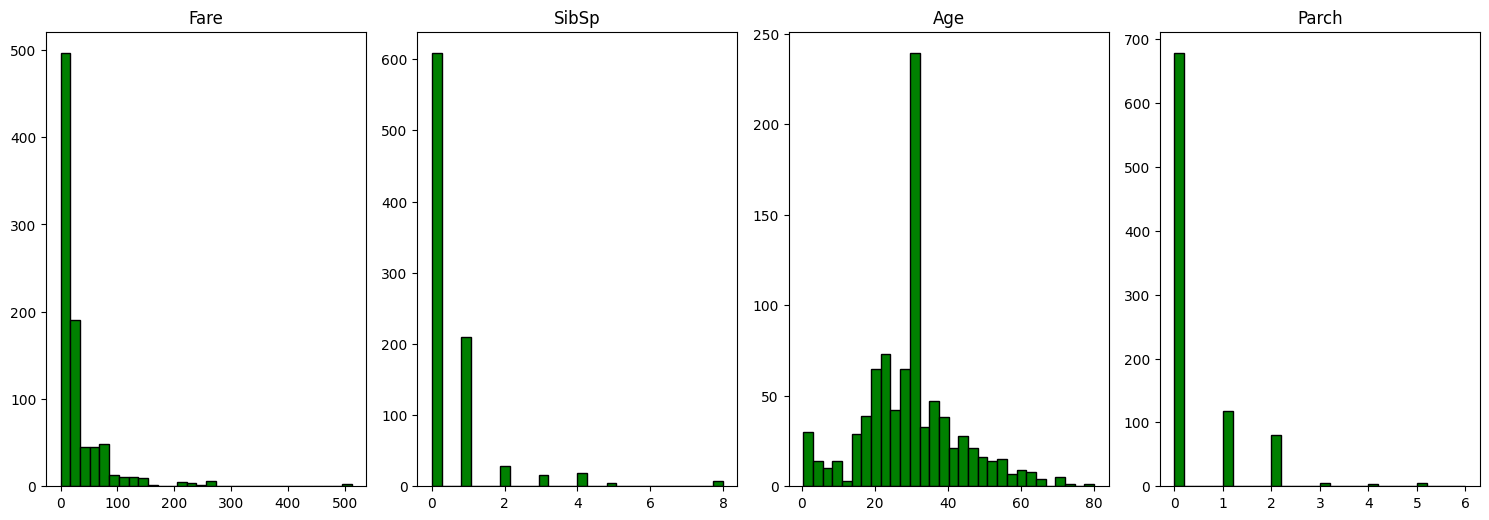

In [609]:

numerical_features = {"Age",  "SibSp",  "Parch",  "Fare" }
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5 * 2))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    axes[i].hist(train_data[col], bins=30, color='g', edgecolor='black')
    axes[i].set_title(f'{col}')


for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<h4>Next step is to do analysis using different clustering algorithms (DBSCAN, K-means, Agglomerative Clustering) combined with dimensionality reduction techniques (t-SNE, PCA). These methods will help analyze and visualize the data by reducing its dimensionality for 2D representation.</h4>

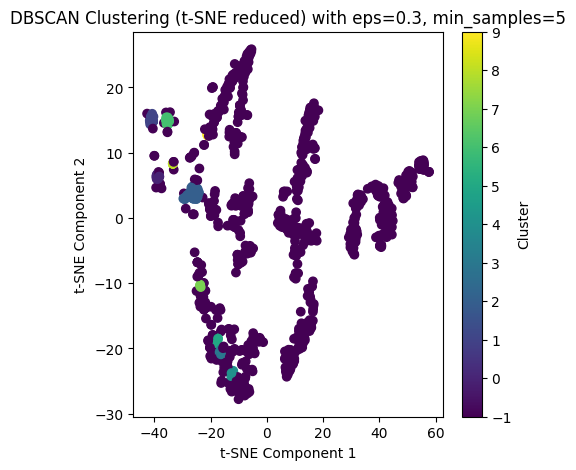

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.588387  0.411613
 0        0.909091  0.090909
 1        0.176471  0.823529
 2        0.941176  0.058824
 3        0.875000  0.125000
 4        0.875000  0.125000
 5        1.000000       NaN
 6        0.933333  0.066667
 7        1.000000       NaN
 8        1.000000       NaN
 9        0.500000  0.500000


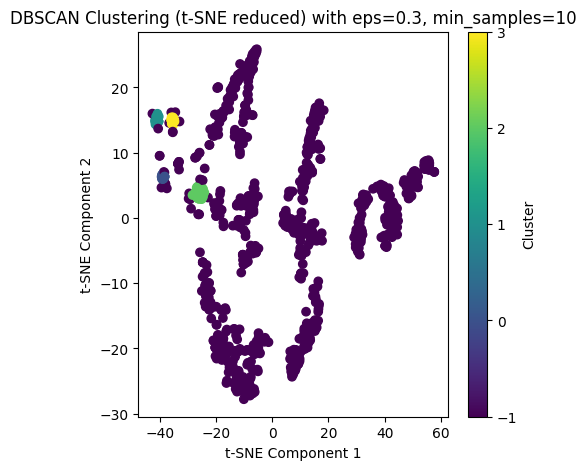

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.604396  0.395604
 0        0.909091  0.090909
 1        0.176471  0.823529
 2        0.931034  0.068966
 3        0.933333  0.066667


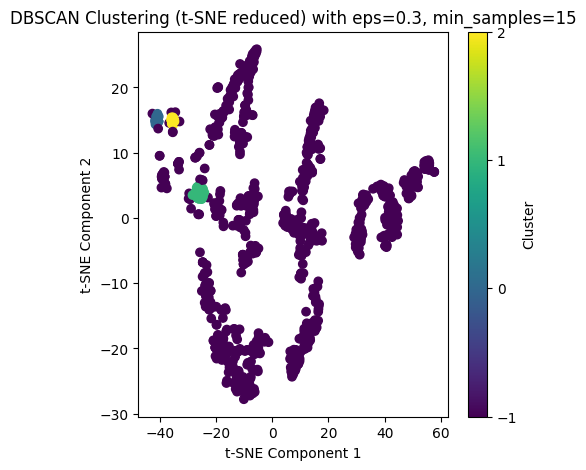

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.608434  0.391566
 0        0.176471  0.823529
 1        0.931034  0.068966
 2        0.933333  0.066667


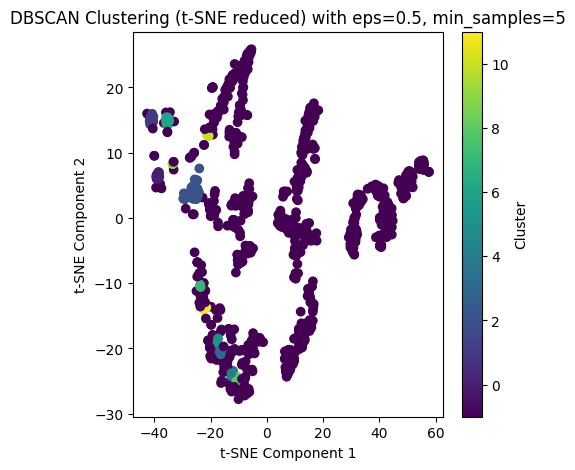

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.579017  0.420983
 0        0.923077  0.076923
 1        0.176471  0.823529
 2        0.948718  0.051282
 3        0.888889  0.111111
 4        0.875000  0.125000
 5        1.000000       NaN
 6        0.933333  0.066667
 7        1.000000       NaN
 8        0.800000  0.200000
 9        1.000000       NaN
 10       0.571429  0.428571
 11       0.800000  0.200000


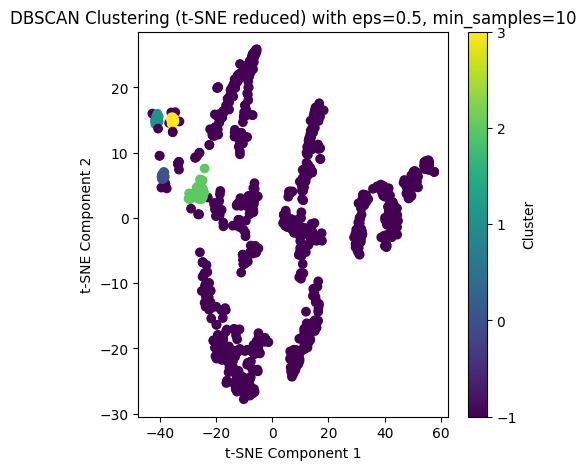

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.598513  0.401487
 0        0.923077  0.076923
 1        0.176471  0.823529
 2        0.948718  0.051282
 3        0.933333  0.066667


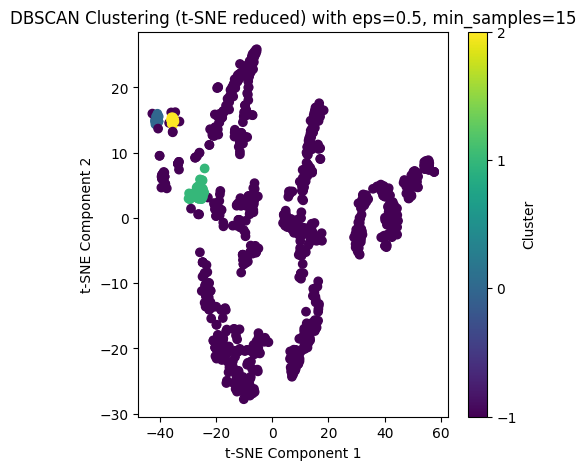

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.603659  0.396341
 0        0.176471  0.823529
 1        0.948718  0.051282
 2        0.933333  0.066667


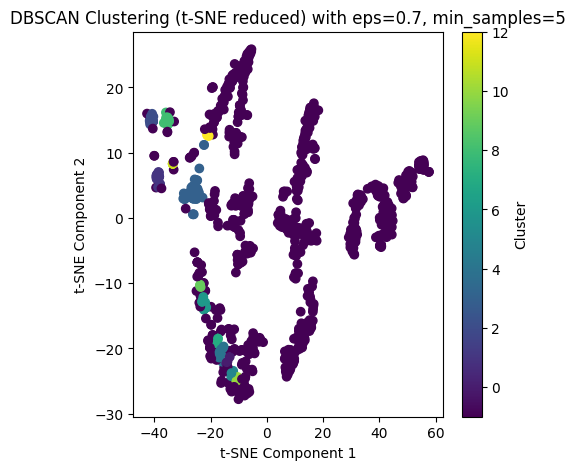

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.568088  0.431912
 0        1.000000       NaN
 1        0.875000  0.125000
 2        0.176471  0.823529
 3        0.933333  0.066667
 4        0.916667  0.083333
 5        0.875000  0.125000
 6        0.916667  0.083333
 7        1.000000       NaN
 8        0.882353  0.117647
 9        1.000000       NaN
 10       0.800000  0.200000
 11       1.000000       NaN
 12       0.571429  0.428571


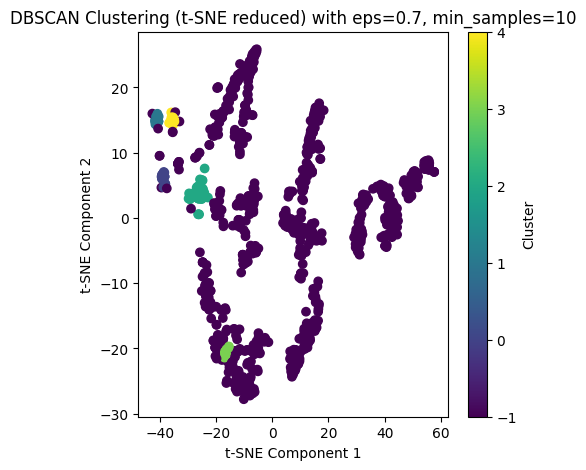

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.592122  0.407878
 0        0.875000  0.125000
 1        0.176471  0.823529
 2        0.953488  0.046512
 3        0.909091  0.090909
 4        0.882353  0.117647


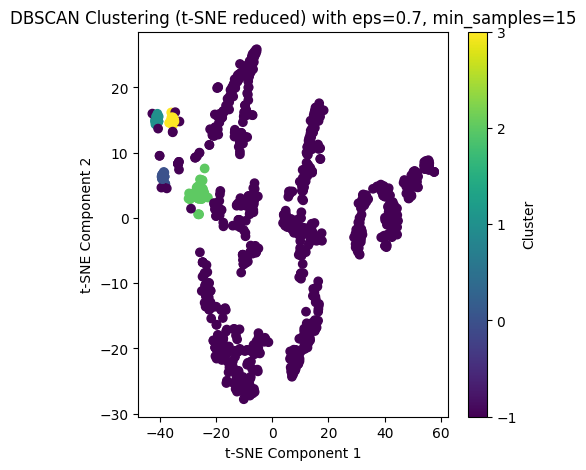

The probability of survival in each cluster :
Survived         0         1
Cluster                     
-1        0.595745  0.404255
 0        0.933333  0.066667
 1        0.176471  0.823529
 2        0.953488  0.046512
 3        0.882353  0.117647


In [618]:


def dbscan_tsne(eps, min_samples, train_data_sample, train_data_target):

    # Using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_components = tsne.fit_transform(train_data_sample)

    # Using DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(train_data_sample)

    # Draw graph with t-SNE
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(f'DBSCAN Clustering (t-SNE reduced) with eps={eps}, min_samples={min_samples}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    cbar = plt.colorbar(label='Cluster')
    cbar.locator = MaxNLocator(integer=True)
    cbar.update_ticks()
    plt.show()

    # Create new data frame, which includs t-SNE components, cluster lables, and survived 
    cluster_data = pd.DataFrame(tsne_components, columns=['TSNE_Component_1', 'TSNE_Component_2'])
    cluster_data['Cluster'] = cluster_labels
    cluster_data['Survived'] = train_data_target

     # Calculate the probability of survival in each cluster 
    probabilities = cluster_data.groupby('Cluster')['Survived'].value_counts(normalize=True).unstack()

    # Print probability
    print("The probability of survival in each cluster :")
    print(probabilities)


train_data_sample_dbscan_tsne = train_data.drop(columns=['Survived']) 
train_data_target_dbscan_tsne = train_data['Survived']

for eps in [0.3, 0.5, 0.7]:
    for min_samples in [5, 10, 15]:
        dbscan_tsne(eps, min_samples, train_data_sample_dbscan_tsne, train_data_target_dbscan_tsne)


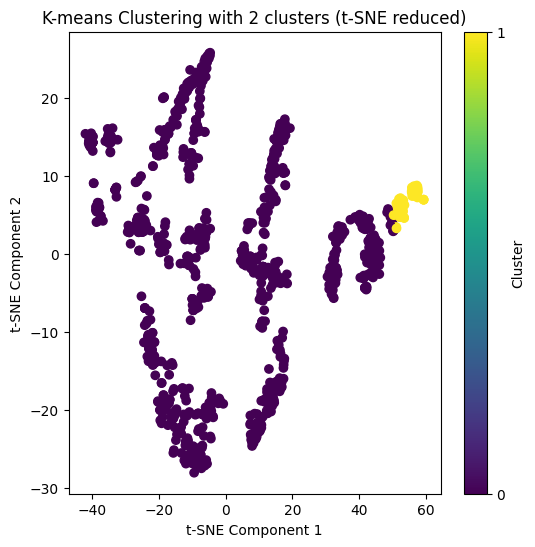

The probability of survival in each cluster:
Survived         0         1
Cluster                     
0         0.634865  0.365135
1         0.238095  0.761905


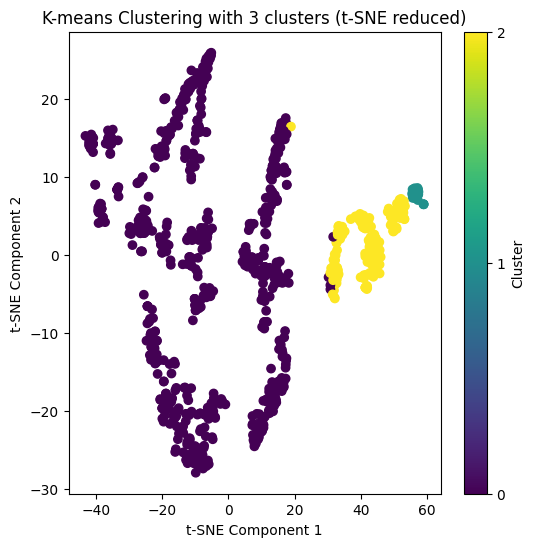

The probability of survival in each cluster:
Survived         0         1
Cluster                     
0         0.680384  0.319616
1         0.300000  0.700000
2         0.330986  0.669014


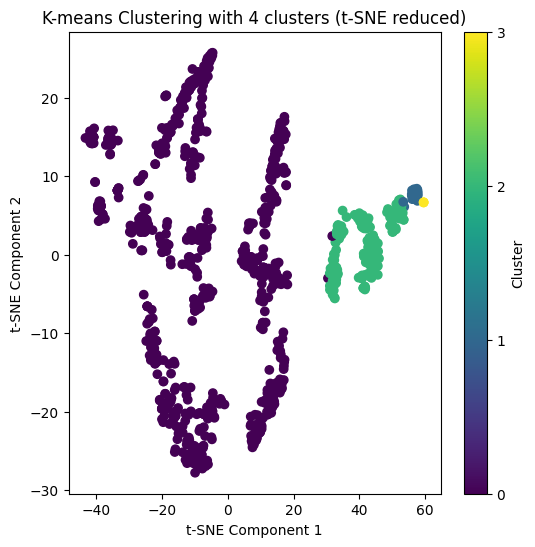

The probability of survival in each cluster:
Survived         0         1
Cluster                     
0         0.682256  0.317744
1         0.315789  0.684211
2         0.330986  0.669014
3              NaN  1.000000


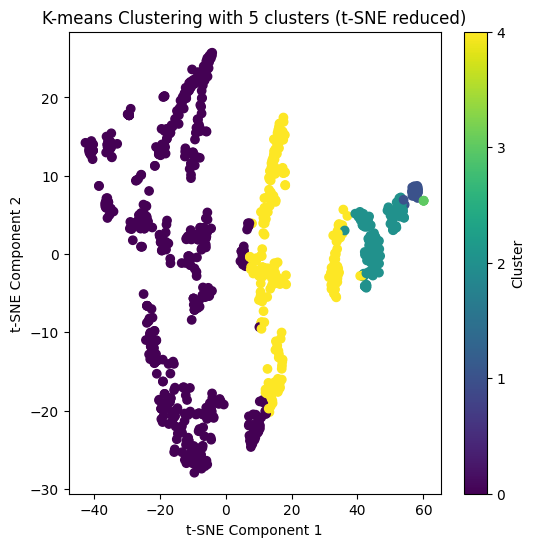

The probability of survival in each cluster:
Survived         0         1
Cluster                     
0         0.709324  0.290676
1         0.315789  0.684211
2         0.326316  0.673684
3              NaN  1.000000
4         0.546256  0.453744


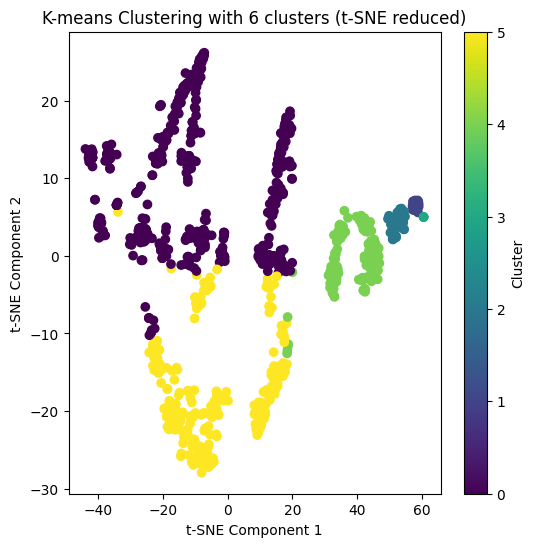

The probability of survival in each cluster:
Survived         0         1
Cluster                     
0         0.702882  0.297118
1         0.352941  0.647059
2         0.242424  0.757576
3              NaN  1.000000
4         0.394958  0.605042
5         0.638060  0.361940


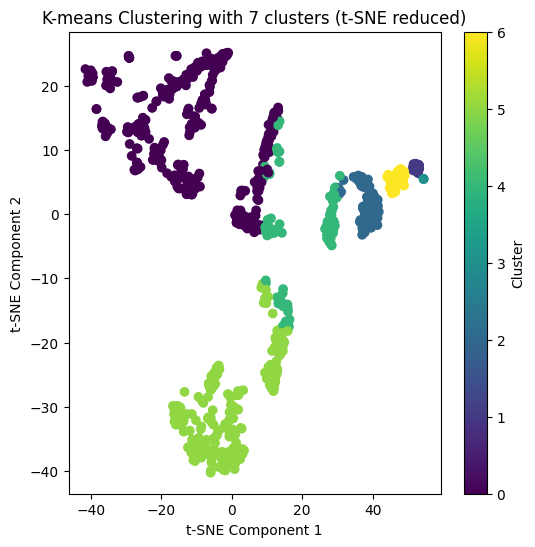

The probability of survival in each cluster:
Survived         0         1
Cluster                     
0         0.715311  0.284689
1         0.352941  0.647059
2         0.371429  0.628571
3              NaN  1.000000
4         0.484848  0.515152
5         0.645418  0.354582
6         0.242424  0.757576


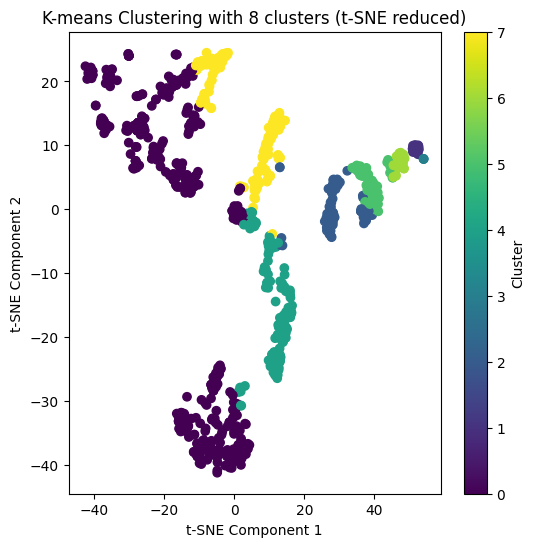

The probability of survival in each cluster:
Survived         0         1
Cluster                     
0         0.738938  0.261062
1         0.352941  0.647059
2         0.464789  0.535211
3              NaN  1.000000
4         0.492537  0.507463
5         0.277778  0.722222
6         0.160000  0.840000
7         0.674074  0.325926


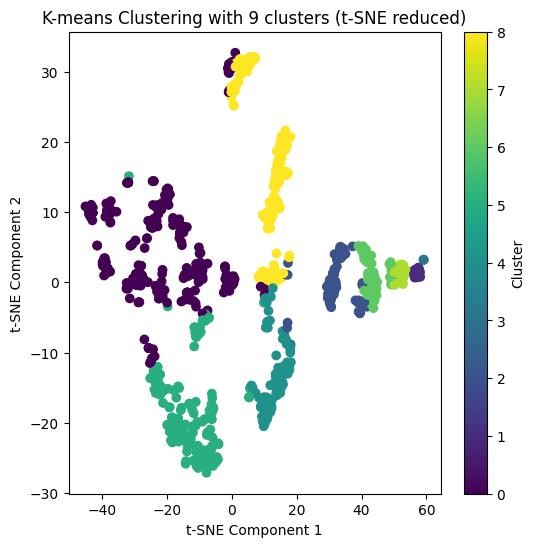

The probability of survival in each cluster:
Survived         0         1
Cluster                     
0         0.741722  0.258278
1         0.352941  0.647059
2         0.472222  0.527778
3              NaN  1.000000
4         0.431818  0.568182
5         0.745763  0.254237
6         0.263158  0.736842
7         0.181818  0.818182
8         0.627451  0.372549


In [619]:
def kmeans_tsne (cluster_number, train_data_sample, train_data_target):

    # Using t-SNE
    tsne = TSNE(n_components=2, random_state=40)
    tsne_components = tsne.fit_transform(train_data_sample)  

    # Using K-means
    kmeans = KMeans(n_clusters=cluster_number, random_state=40)
    kmeans.fit(train_data_sample)
    cluster_labels = kmeans.labels_

    train_data_sample['Cluster'] = cluster_labels

    # Draw graph with t-SNE
    plt.figure(figsize=(6, 6))
    plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(f'K-means Clustering with {cluster_number} clusters (t-SNE reduced)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    cbar = plt.colorbar(label='Cluster')
    cbar.locator = MaxNLocator(integer=True)
    cbar.update_ticks()
    plt.show()

    # Create new data frame, which includs t-SNE components, cluster lables, and survived 
    cluster_data = pd.DataFrame(tsne_components, columns=['TSNE_Component_1', 'TSNE_Component_2'])
    cluster_data['Cluster'] = cluster_labels
    cluster_data['Survived'] = train_data_target 

     # Calculate the probability of survival in each cluster 
    probabilities = cluster_data.groupby('Cluster')['Survived'].value_counts(normalize=True).unstack()

    # Print probability
    print("The probability of survival in each cluster:")
    print(probabilities)


train_data_sample_kmeans_tsne = train_data.drop(columns=['Survived']) 
train_data_target_kmeans_tsne = train_data['Survived']

for cluster_number in range(2, 10):
   kmeans_tsne(cluster_number, train_data_sample_kmeans_tsne, train_data_target_kmeans_tsne)

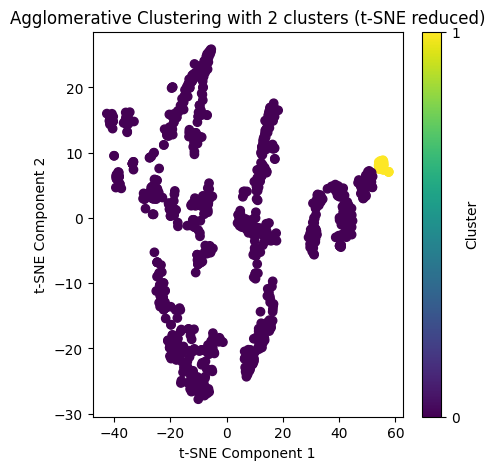

The probability of survival in each cluster :
Survived         0         1
Cluster                     
0         0.623421  0.376579
1         0.300000  0.700000


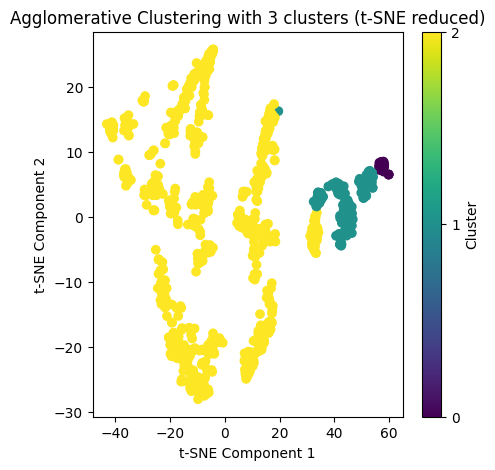

The probability of survival in each cluster :
Survived         0         1
Cluster                     
0         0.300000  0.700000
1         0.347826  0.652174
2         0.665344  0.334656


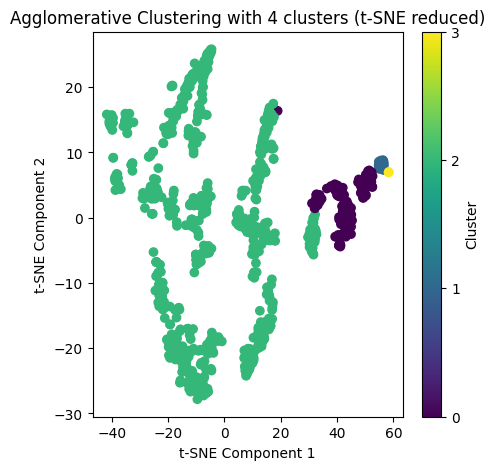

The probability of survival in each cluster :
Survived         0         1
Cluster                     
0         0.347826  0.652174
1         0.352941  0.647059
2         0.665344  0.334656
3              NaN  1.000000


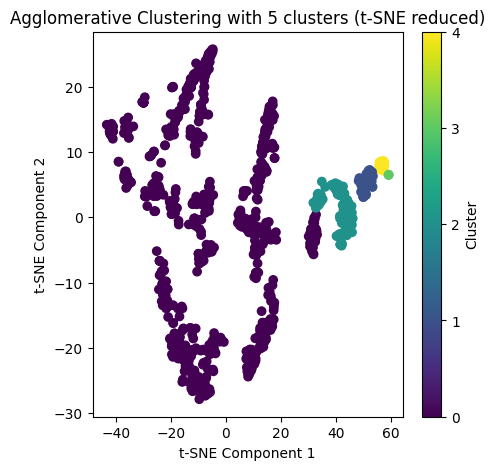

The probability of survival in each cluster :
Survived         0         1
Cluster                     
0         0.665344  0.334656
1         0.242424  0.757576
2         0.390244  0.609756
3              NaN  1.000000
4         0.352941  0.647059


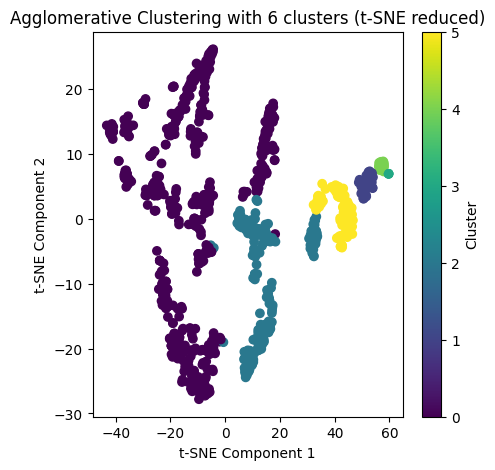

The probability of survival in each cluster :
Survived         0         1
Cluster                     
0         0.733333  0.266667
1         0.242424  0.757576
2         0.456989  0.543011
3              NaN  1.000000
4         0.352941  0.647059
5         0.390244  0.609756


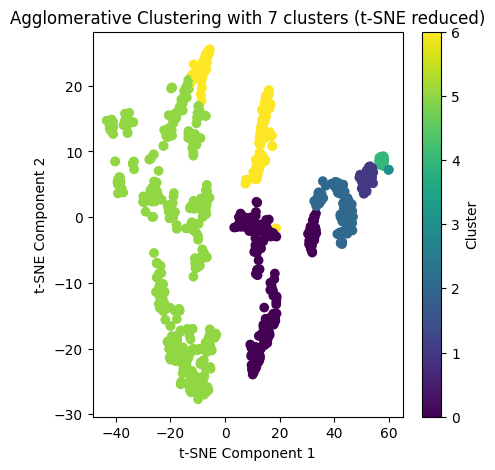

The probability of survival in each cluster :
Survived         0         1
Cluster                     
0         0.456989  0.543011
1         0.242424  0.757576
2         0.390244  0.609756
3              NaN  1.000000
4         0.352941  0.647059
5         0.742794  0.257206
6         0.697479  0.302521


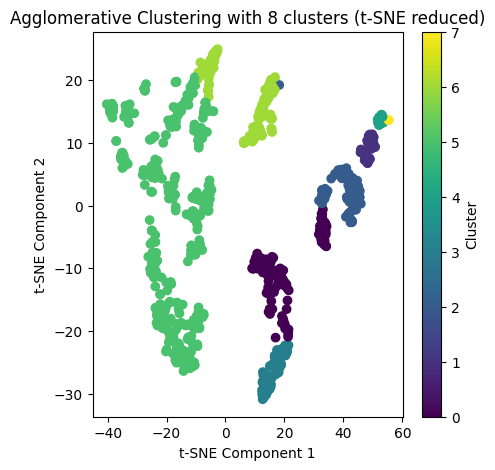

The probability of survival in each cluster :
Survived         0         1
Cluster                     
0         0.479675  0.520325
1         0.242424  0.757576
2         0.390244  0.609756
3         0.412698  0.587302
4         0.352941  0.647059
5         0.742794  0.257206
6         0.697479  0.302521
7              NaN  1.000000


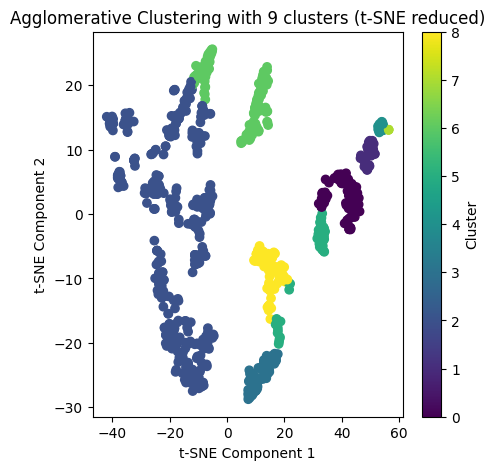

The probability of survival in each cluster :
Survived         0         1
Cluster                     
0         0.390244  0.609756
1         0.242424  0.757576
2         0.742794  0.257206
3         0.412698  0.587302
4         0.352941  0.647059
5         0.466667  0.533333
6         0.697479  0.302521
7              NaN  1.000000
8         0.487179  0.512821


In [620]:
def agg_tsne(cluster_number, train_data_sample, train_data_target):
    
    # Using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_components = tsne.fit_transform(train_data_sample)

    # Using K-means
    agg= AgglomerativeClustering(n_clusters=cluster_number, linkage='ward')  # linkage = 'ward' or 'complete' or 'average' or 'single'
    cluster_labels = agg.fit_predict(train_data)

    train_data_sample['Cluster'] = cluster_labels

    # Draw graph with t-SNE
    plt.figure(figsize=(5, 5))
    plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(f'Agglomerative Clustering with {cluster_number} clusters (t-SNE reduced)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    cbar = plt.colorbar(label='Cluster')
    cbar.locator = MaxNLocator(integer=True)
    cbar.update_ticks()
    plt.show()

    # Create new data frame, which includs t-SNE components, cluster lables, and survived 
    cluster_data = pd.DataFrame(tsne_components, columns=['TSNE_Component_1', 'TSNE_Component_2'])
    cluster_data['Cluster'] = cluster_labels 
    cluster_data['Survived'] = train_data_target 

    # Calculate the probability of survival in each cluster 
    probabilities = cluster_data.groupby('Cluster')['Survived'].value_counts(normalize=True).unstack()

    # Print probability
    print("The probability of survival in each cluster :")
    print(probabilities)



train_data_sample_agg_tsne = train_data.drop(columns=['Survived']) 
train_data_target_agg_tsne = train_data['Survived']

for cluster_number in range(2, 10):
    agg_tsne(cluster_number, train_data_sample_agg_tsne, train_data_target_agg_tsne)

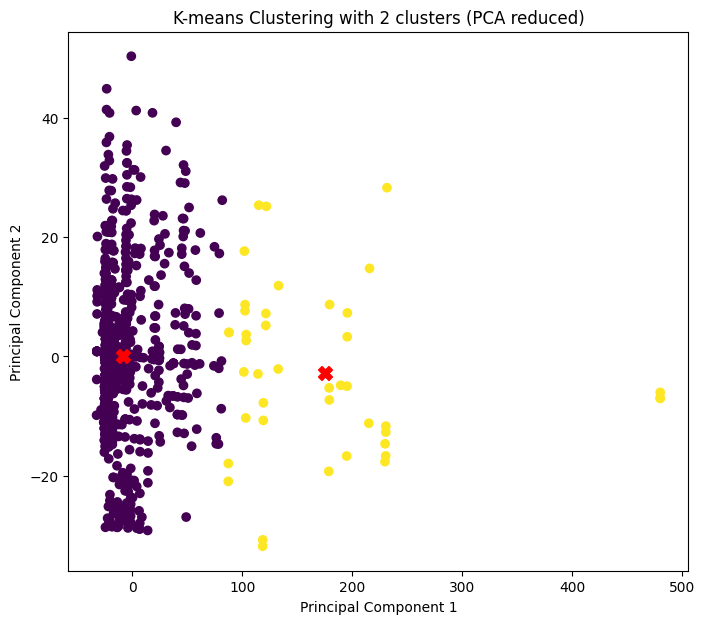

Вероятности классов в кластерах (PCA):
Survived         0         1
Cluster                     
0         0.634865  0.365135
1         0.238095  0.761905


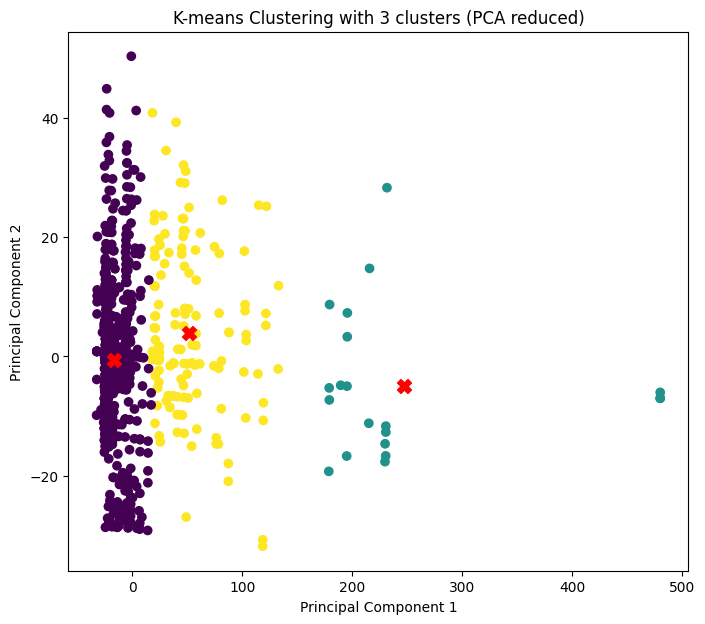

Вероятности классов в кластерах (PCA):
Survived         0         1
Cluster                     
0         0.680384  0.319616
1         0.300000  0.700000
2         0.330986  0.669014


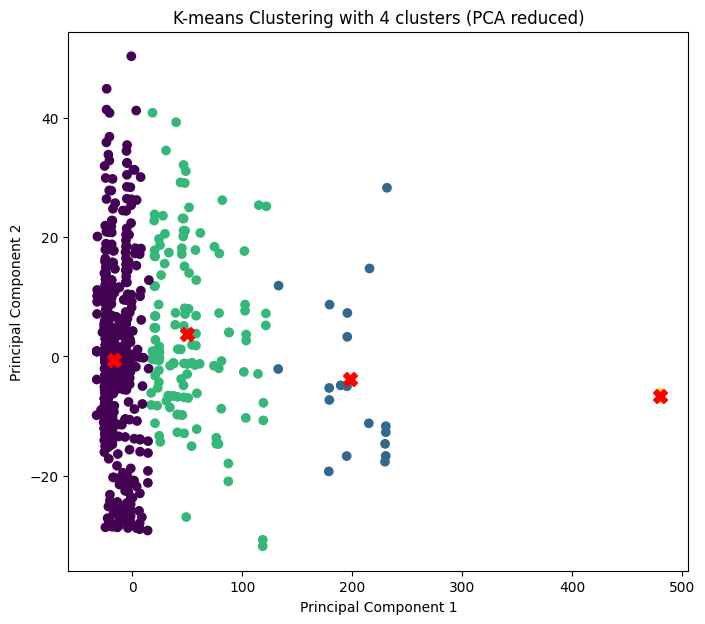

Вероятности классов в кластерах (PCA):
Survived         0         1
Cluster                     
0         0.682256  0.317744
1         0.315789  0.684211
2         0.330986  0.669014
3              NaN  1.000000


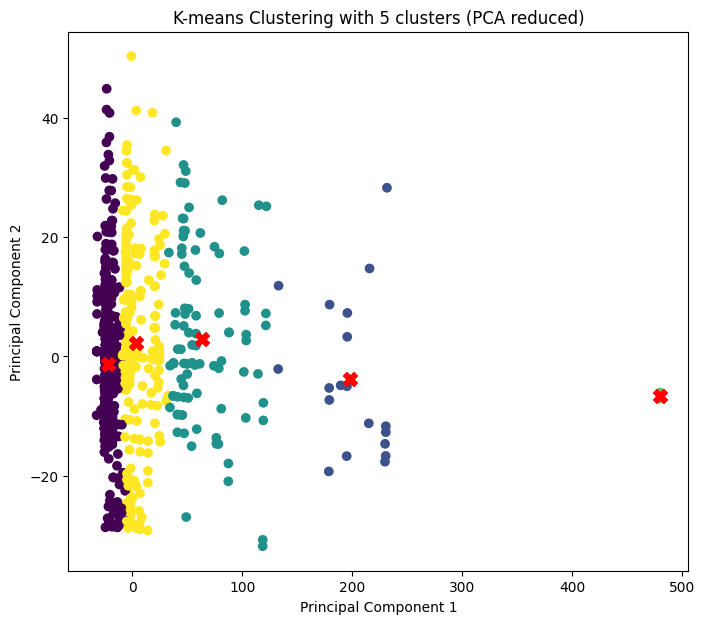

Вероятности классов в кластерах (PCA):
Survived         0         1
Cluster                     
0         0.709324  0.290676
1         0.315789  0.684211
2         0.326316  0.673684
3              NaN  1.000000
4         0.546256  0.453744


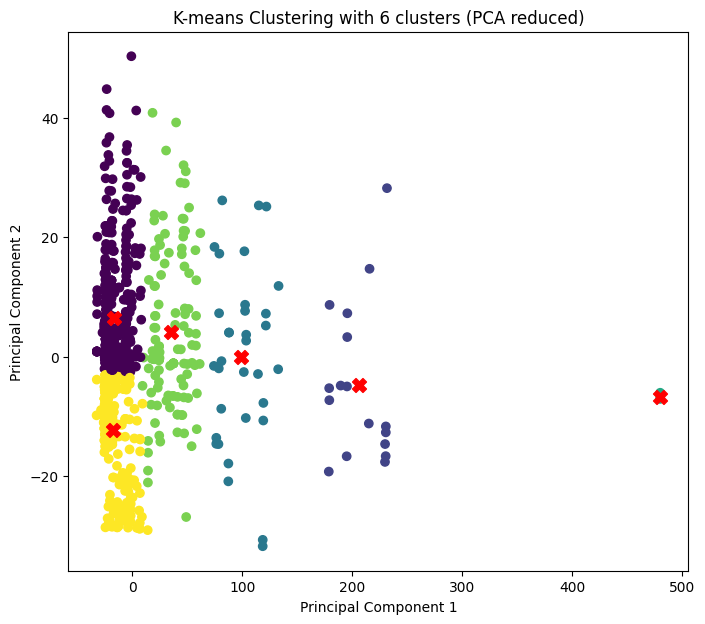

Вероятности классов в кластерах (PCA):
Survived         0         1
Cluster                     
0         0.702882  0.297118
1         0.352941  0.647059
2         0.242424  0.757576
3              NaN  1.000000
4         0.394958  0.605042
5         0.638060  0.361940


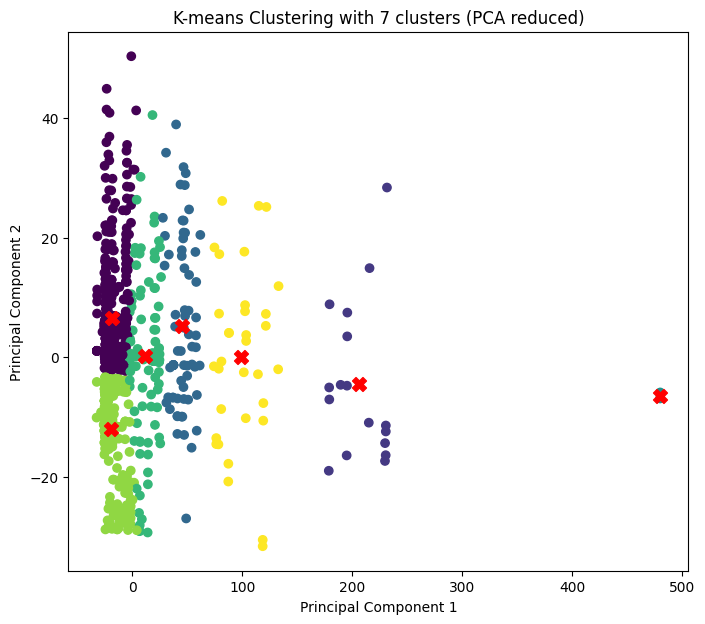

Вероятности классов в кластерах (PCA):
Survived         0         1
Cluster                     
0         0.715311  0.284689
1         0.352941  0.647059
2         0.371429  0.628571
3              NaN  1.000000
4         0.484848  0.515152
5         0.645418  0.354582
6         0.242424  0.757576


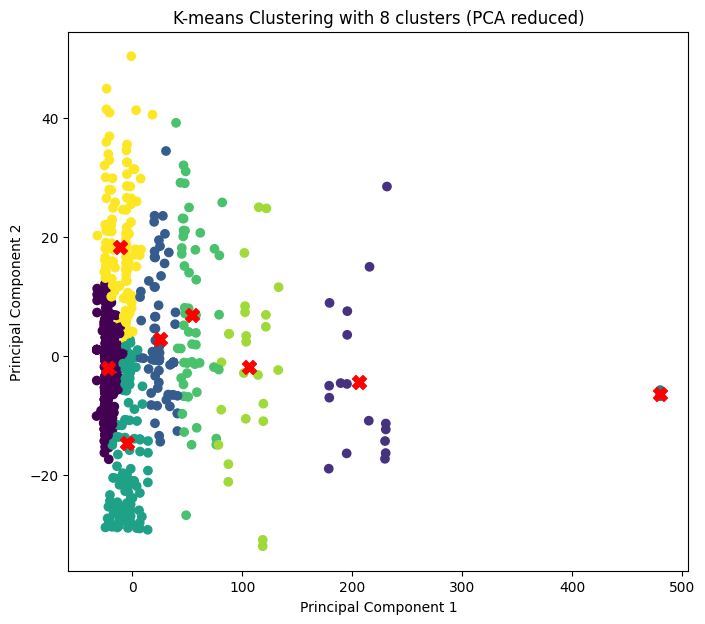

Вероятности классов в кластерах (PCA):
Survived         0         1
Cluster                     
0         0.738938  0.261062
1         0.352941  0.647059
2         0.464789  0.535211
3              NaN  1.000000
4         0.492537  0.507463
5         0.277778  0.722222
6         0.160000  0.840000
7         0.674074  0.325926


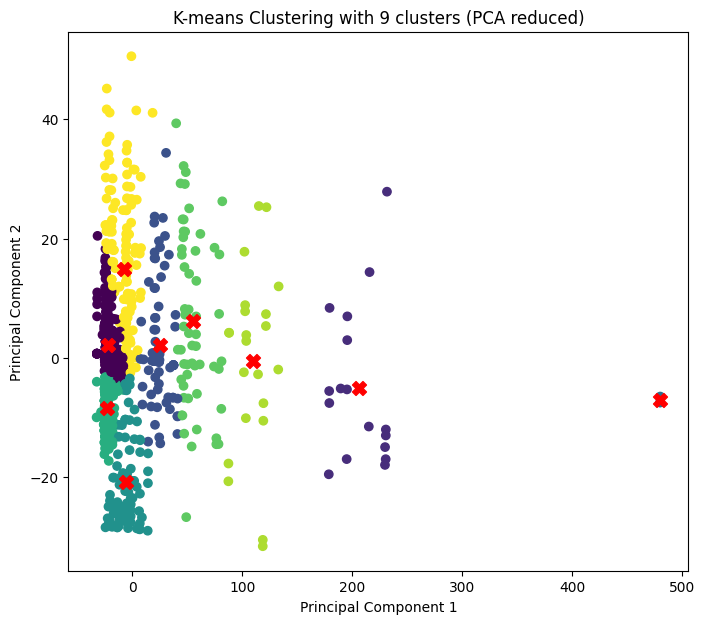

Вероятности классов в кластерах (PCA):
Survived         0         1
Cluster                     
0         0.741722  0.258278
1         0.352941  0.647059
2         0.472222  0.527778
3              NaN  1.000000
4         0.431818  0.568182
5         0.745763  0.254237
6         0.263158  0.736842
7         0.181818  0.818182
8         0.627451  0.372549


In [621]:
def kmeans_pca(cluster_number, train_data_sample, train_data_target):

    # Using PCA 
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(train_data_sample)  

    # Using K-means
    kmeans = KMeans(n_clusters=cluster_number, random_state=40)
    kmeans.fit(train_data_sample) 
    cluster_labels = kmeans.labels_ 
    centroids = kmeans.cluster_centers_

    # Using PCA for centroids
    centroids_pca = pca.transform(centroids)

    train_data_sample['Cluster'] = cluster_labels

    # Draw graph with PCA
    plt.figure(figsize=(8, 7))
    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=cluster_labels, cmap='viridis')
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='red', marker='X')
    plt.title(f'K-means Clustering with {cluster_number} clusters (PCA reduced)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    # Create new data frame, which includs PCA components, cluster lables, and survived 
    cluster_data = pd.DataFrame(pca_components, columns=['PCA_Component_1', 'PCA_Component_2'])
    cluster_data['Cluster'] = cluster_labels  
    cluster_data['Survived'] = train_data_target 

    # Calculate the probability of survival in each cluster 
    probabilities = cluster_data.groupby('Cluster')['Survived'].value_counts(normalize=True).unstack()

    # Print probability
    print("Вероятности классов в кластерах (PCA):")
    print(probabilities)


train_data_sample_kmeans_pca = train_data.drop(columns=['Survived'])  
train_data_target_kmeans_pca = train_data['Survived'] 

for cluster_number in range(2, 10):
    kmeans_pca(cluster_number, train_data_sample_kmeans_pca, train_data_target_kmeans_pca)